# LeNet5

In [ ]:
%load_ext autoreload
%autoreload 2

In [23]:
from aye import AyeModule, Learner 
from aye.callbacks import LRFinderCallback, MetricsCallback, EarlyStopping, ActivationStats
from aye.metrics import confusion_matrix
from aye.models.init import init_cnn_weights
from aye.models.lenet import LeNet5
from aye.utils import show_images
from functools import partial

import torch
import torch.nn as nn 
import torch.nn.functional as F 

from torcheval.metrics import MulticlassAccuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset: MNIST

In [3]:
from aye.data_modules.mnist import MNIST

If you want to use other data modules, then you can replace the above import with one from the following:

```python
from aye.data_modules.cifar import CIFAR10
from aye.data_modules.fashion_mnist import FashionMNIST
from aye.data_modules.hotdog import HotDog
```

And instantiate the dataset below accordingly:

In [ ]:
dataset = MNIST()

In [ ]:

dataset.prepare_data()
dataset.setup()
dataset.batch_size = 1024

train_dl, val_dl, test_dl = dataset.train_dataloader(), dataset.val_dataloader(), dataset.test_dataloader()

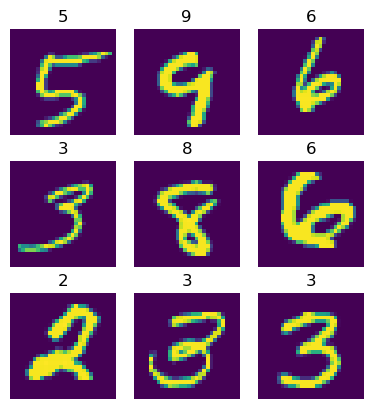

In [18]:
samples = next(iter(train_dl))
show_images(samples, mapping = dataset.mapping, nrows = 3, ncols = 3)

In [7]:
lenet = LeNet5(act = nn.ReLU())
lenet.summary(x_shape = (dataset.batch_size, 1, 28, 28))

------------------------------------------------------------------------------
        layer (type)                         output size               params
              Conv2d       torch.Size([1024, 6, 28, 28])                  156
                ReLU       torch.Size([1024, 6, 28, 28])                    0
           AvgPool2d       torch.Size([1024, 6, 14, 14])                    0
              Conv2d      torch.Size([1024, 16, 10, 10])                 2416
                ReLU      torch.Size([1024, 16, 10, 10])                    0
           AvgPool2d        torch.Size([1024, 16, 5, 5])                    0
             Flatten             torch.Size([1024, 400])                    0
              Linear             torch.Size([1024, 120])                48120
                ReLU             torch.Size([1024, 120])                    0
              Linear              torch.Size([1024, 84])                10164
                ReLU              torch.Size([1024, 84])       

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

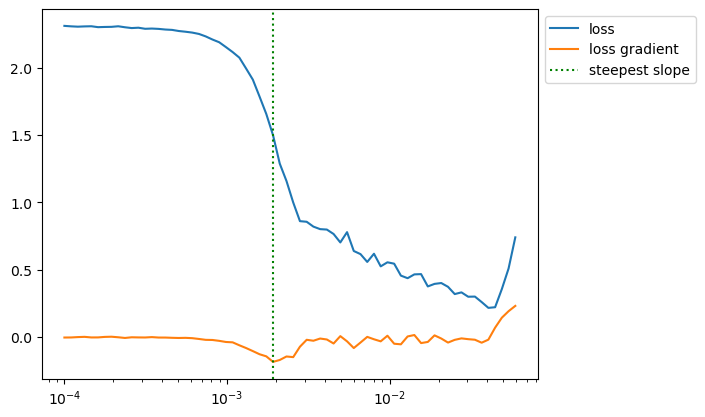

In [15]:
model = LeNet5(lr = 1e-4, act = nn.ReLU()).to(device)
lr_finder = LRFinderCallback(lr_multiplier = 1.1)
learner = Learner(accelerator = "cuda", callbacks = [lr_finder], enable_checkpointing = False)
learner.fit(model, train_dl, val_dl)
lr_finder.plot(grads = True)

In [21]:
model.lr = lr_finder.suggest()
model.apply_init(next(iter(train_dl))[0].to(device), partial(init_cnn_weights, leaky = 0.1))
metrics = MetricsCallback(acc = MulticlassAccuracy())
act_stats = ActivationStats(modules = list(model.modules())[1:], module_filter = nn.ReLU)
learner = Learner(accelerator = device, max_epochs = 5, callbacks = [metrics, act_stats], enable_checkpointing = False)
learner.fit(model, train_dl, val_dl)

  0%|          | 0/59 [00:00<?, ?it/s]

{'epoch': 0, 'train_acc': '0.7251', 'val_acc': '0.9398', 'train_loss': '1.1078', 'val_loss': '0.2046'}


  0%|          | 0/59 [00:00<?, ?it/s]

{'epoch': 1, 'train_acc': '0.9468', 'val_acc': '0.9602', 'train_loss': '0.1726', 'val_loss': '0.1255'}


  0%|          | 0/59 [00:00<?, ?it/s]

{'epoch': 2, 'train_acc': '0.9629', 'val_acc': '0.9700', 'train_loss': '0.1209', 'val_loss': '0.0971'}


  0%|          | 0/59 [00:00<?, ?it/s]

{'epoch': 3, 'train_acc': '0.9705', 'val_acc': '0.9748', 'train_loss': '0.0970', 'val_loss': '0.0816'}


  0%|          | 0/59 [00:00<?, ?it/s]

{'epoch': 4, 'train_acc': '0.9752', 'val_acc': '0.9786', 'train_loss': '0.0800', 'val_loss': '0.0747'}


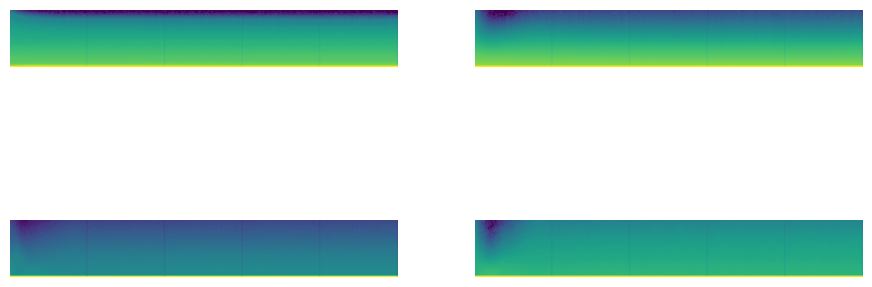

In [22]:
act_stats.color_dim()

c:\Users\NITRO5\miniconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


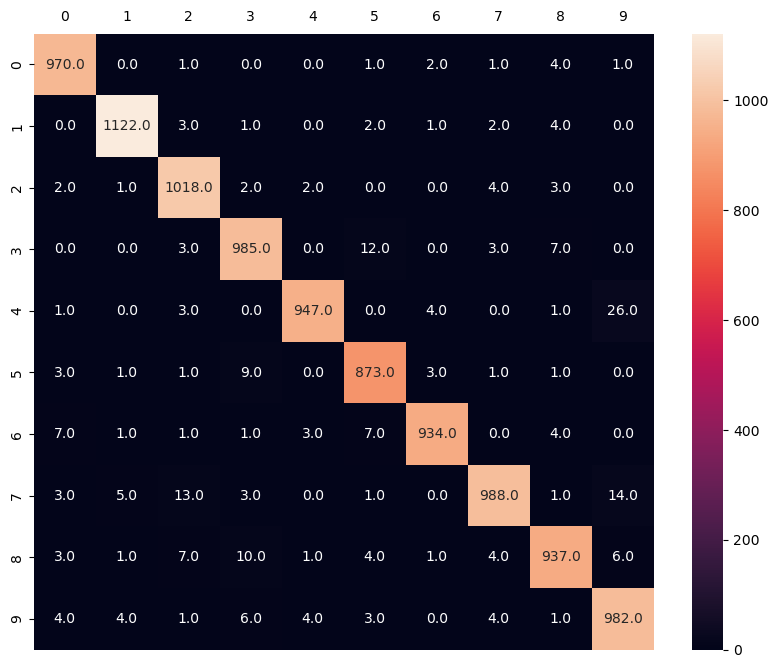

In [24]:
confusion_matrix(10, model, dataset)

In [62]:
def predict(model, x):
    y = model.predict_step(x.to(device))
    return torch.argmax(y)

In [67]:
samples = next(iter(train_dl))
x = samples[0][0]
predict(model, x[None, :, :, :])

tensor(2, device='cuda:0')

<Axes: >

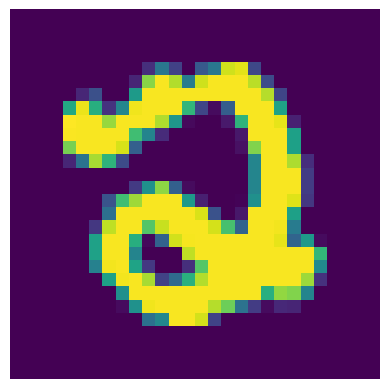

In [68]:
show_images(x)